# Air Pollution by Politics

## Imports & Installs

In [1]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import os
import json
from scipy.signal import argrelextrema
from refs import state_abbreviation_dict


! pip install xlrd
! pip install openpyxl

## Loads

In [2]:
presidential_data = pd.read_csv('data/election/relevant/usa/1976-2020-president.csv')
senate_data = pd.read_csv('data/election/relevant/usa/1976-2020-senate.csv')
house_data = pd.read_csv('data/election/relevant/usa/1976-2022-house.csv')
house_data['party_simplified'] = house_data['party'].apply(lambda x: x if x in ['DEMOCRAT', 'REPUBLICAN'] else 'OTHER')

state_emissions_data = pd.read_excel(
    "data/co2_emissions/relevant/1970-2022-state_emissions.xlsx",
    engine="openpyxl",
    skiprows=4
)

state_population_size_data = pd.read_csv('data/general_state_data/population_data.csv')
state_population_size_data.rename(columns={'AK': 'state', '1950': 'year', '135000': 'population'}, inplace=True)
state_land_size_data = pd.read_csv('data/general_state_data/state_sizes.csv')

##  Analysis Per Category

### Election Analysis

This code calculates a political score for each U.S. state based on presidential, House, and Senate election data. It processes the election data for each year, calculates political scores by considering factors like vote percentage, longest streak of party wins, and the party of the most recent winner. It then combines these scores using weighted averages for each state and year. The final political scores are scaled and adjusted using the `MinMaxScaler`, and the scores are returned in a DataFrame, where each row represents a state’s political score for a specific year. This method provides insights into state-level political trends over time.

In [3]:
def calculate_scores_by_year(presidential_data, house_data, senate_data):
    years = sorted(presidential_data['year'].unique())
    all_scores = []

    for year in years:
        pres_results = calculate_political_scores(presidential_data, year)
        house_results = calculate_political_scores(house_data, year)
        sen_results = calculate_political_scores(senate_data, year)
        final_political_score = merge_and_average_scores(house_results, sen_results, pres_results, year)
        all_scores.append(final_political_score)

    return pd.concat(all_scores).reset_index(drop=True)

def calculate_political_scores(df, year=2020):
    df = df[df['year'] <= year].copy()  # Ensure a full copy is made
    df_filtered = df[df['party_simplified'].isin(['DEMOCRAT', 'REPUBLICAN'])].copy()

    df_filtered.loc[:, 'vote_percent'] = df_filtered['candidatevotes'] / df_filtered['totalvotes'] * 100

    df_winner = df_filtered.loc[df_filtered.groupby(['year', 'state'])['candidatevotes'].idxmax()].copy()

    state_streaks = {}
    for state in df_winner['state'].unique():
        state_data = df_winner[df_winner['state'] == state].sort_values('year')
        current_party = None
        streak = 0
        max_streak = 0
        last_winner = None

        for _, row in state_data.iterrows():
            if row['party_simplified'] == current_party:
                streak += 1
            else:
                current_party = row['party_simplified']
                streak = 1
            max_streak = max(max_streak, streak)
            last_winner = current_party

        state_streaks[state] = {'longest_streak': max_streak, 'last_winner': last_winner}

    df_summary = df_winner.groupby('state').agg(
        total_elections=('year', 'count'),
        avg_vote_percent=('vote_percent', 'mean'),
        last_winner=('party_simplified', 'last'),
        last_vote_percent=('vote_percent', 'last')
    ).reset_index()

    df_summary['longest_streak'] = df_summary['state'].map(lambda x: state_streaks[x]['longest_streak'])
    df_summary['streak_party'] = df_summary['state'].map(lambda x: state_streaks[x]['last_winner'])

    df_summary['party_numeric'] = df_summary['last_winner'].map({'REPUBLICAN': -1, 'DEMOCRAT': 1})

    features = df_summary[['longest_streak', 'avg_vote_percent', 'last_vote_percent']]

    scaler = MinMaxScaler(feature_range=(-1, 1))
    df_summary.loc[:, ['streak_score', 'avg_vote_score', 'last_vote_score']] = scaler.fit_transform(features)

    df_summary['final_score'] = (df_summary['streak_score'] * 0.4 +
                                 df_summary['avg_vote_score'] * 0.3 +
                                 df_summary['last_vote_score'] * 0.3) * df_summary['party_numeric']
    df_summary['year'] = year
    return df_summary[['state', 'year', 'final_score']]

def merge_and_average_scores(house_results, sen_results, pres_results, year=2020):
    df_combined = house_results.merge(sen_results, on=['state', 'year'], suffixes=('_house', '_sen')) \
                               .merge(pres_results, on=['state', 'year'], suffixes=('', '_pres'))

    df_combined['final_score_avg'] = df_combined[['final_score_house', 'final_score_sen', 'final_score']].mean(axis=1)

    return df_combined[['state', 'year', 'final_score_avg']]

final_political_scores_by_year = calculate_scores_by_year(presidential_data, house_data, senate_data)
final_political_scores_by_year = final_political_scores_by_year.rename(columns={'final_score_avg':'party_affiliation_score'})
final_political_scores_by_year

,state,year,party_affiliation_score
0,ARIZONA,1976,-0.276792
1,CALIFORNIA,1976,0.787895
2,CONNECTICUT,1976,0.701563
3,DELAWARE,1976,0.269130
4,FLORIDA,1976,-0.464138
...,...,...,...
578,VIRGINIA,2020,-0.162847
579,WASHINGTON,2020,0.024978
580,WEST VIRGINIA,2020,-0.181551
581,WISCONSIN,2020,-0.268129


### Emissions Analysis

This code analyzes state-level emissions data by excluding any rows containing "Total" in the state name. It then calculates the average emissions for each state across the available years and identifies the top 10 states with the highest and lowest average emissions. The results are visualized in two separate bar charts: one for the top 10 states with the highest emissions, and another for the top 10 states with the lowest emissions, using red and green colors, respectively. These plots help to easily identify and compare the states based on their average emissions over time.

In [4]:
state_emissions_data

,State,1970,1971,1972,1973,1974,1975,1976,1977,1978,...,2017,2018,2019,2020,2021,2022,Percent,Absolute,Percent.1,Absolute.1
0,Alabama,102.717308,98.516403,104.984789,109.618074,108.831948,107.827892,108.123429,111.715385,106.665665,...,108.072106,111.907375,105.831211,97.977476,108.309051,109.291123,0.063999,6.573815,0.009067,0.982072
1,Alaska,11.358988,12.646215,13.435356,12.506009,12.793869,14.545277,15.991448,17.984787,19.530629,...,33.612044,34.392556,34.157534,35.915884,39.706281,41.304340,2.636269,29.945353,0.040247,1.598060
2,Arizona,24.937739,27.031606,30.257542,34.484241,36.772653,38.248535,43.806707,50.528150,49.310167,...,90.006330,93.647656,92.112163,79.678622,82.631087,81.426926,2.265209,56.489187,-0.014573,-1.204162
3,Arkansas,36.238491,35.147374,37.246511,40.904539,39.181082,36.417068,38.914652,41.698087,42.461084,...,63.822742,70.451214,64.778837,54.420762,61.727600,63.182542,0.743520,26.944050,0.023570,1.454942
4,California,294.672829,306.128867,313.001675,329.536275,304.727911,311.714448,327.104137,354.674419,345.358928,...,354.472039,356.680792,356.513198,301.963000,324.079546,326.205361,0.107009,31.532531,0.006560,2.125815
5,Colorado,43.057661,43.628581,47.509428,51.112474,50.519445,51.833807,55.165689,58.339998,58.471686,...,88.166320,89.412318,91.099265,79.264087,84.663258,88.685173,1.059684,45.627512,0.047505,4.021915
6,Connecticut,47.839723,45.901611,47.222932,48.585809,45.433967,41.695952,43.441472,43.059846,43.977977,...,33.707466,37.239556,36.494940,33.652811,36.331574,37.041873,-0.225709,-10.797851,0.019550,0.710299
7,Delaware,16.051567,15.907361,15.991638,17.221577,16.636428,15.518162,16.131819,16.116363,16.162534,...,13.712744,13.932115,13.540875,12.158646,12.659583,12.664988,-0.210981,-3.386579,0.000427,0.005405
8,District of Columbia,13.642245,11.877348,11.306110,11.850583,9.849625,7.890092,7.690561,7.922985,7.450558,...,2.578868,2.851156,2.799149,2.393873,2.581308,2.645821,-0.806057,-10.996424,0.024992,0.064513
9,Florida,104.403707,111.555148,121.728053,132.294566,124.346429,125.987894,134.577618,138.240436,146.157945,...,237.368371,240.946920,232.630532,206.725204,225.411105,231.001254,1.212577,126.597547,0.024800,5.590150


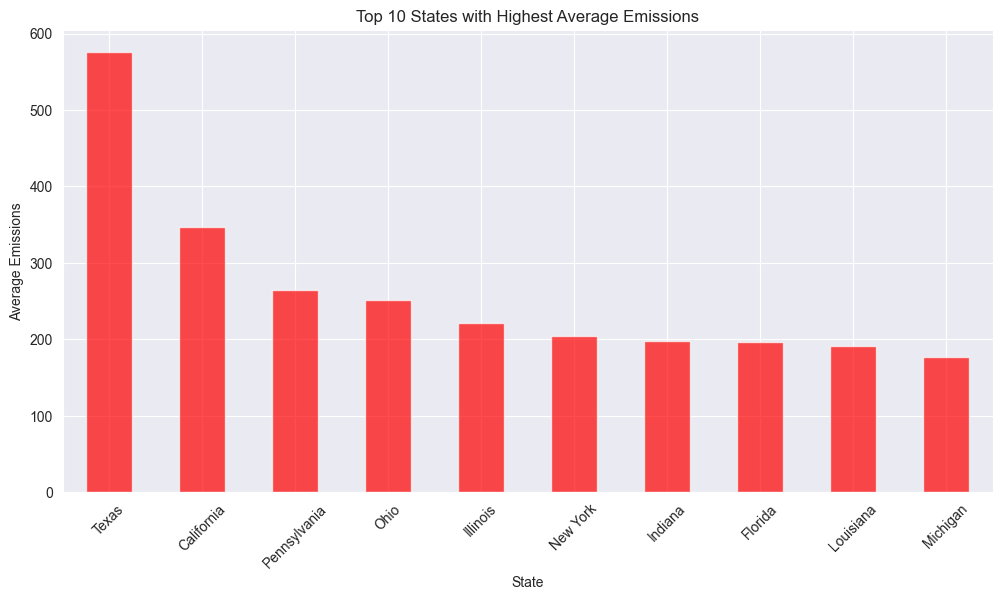

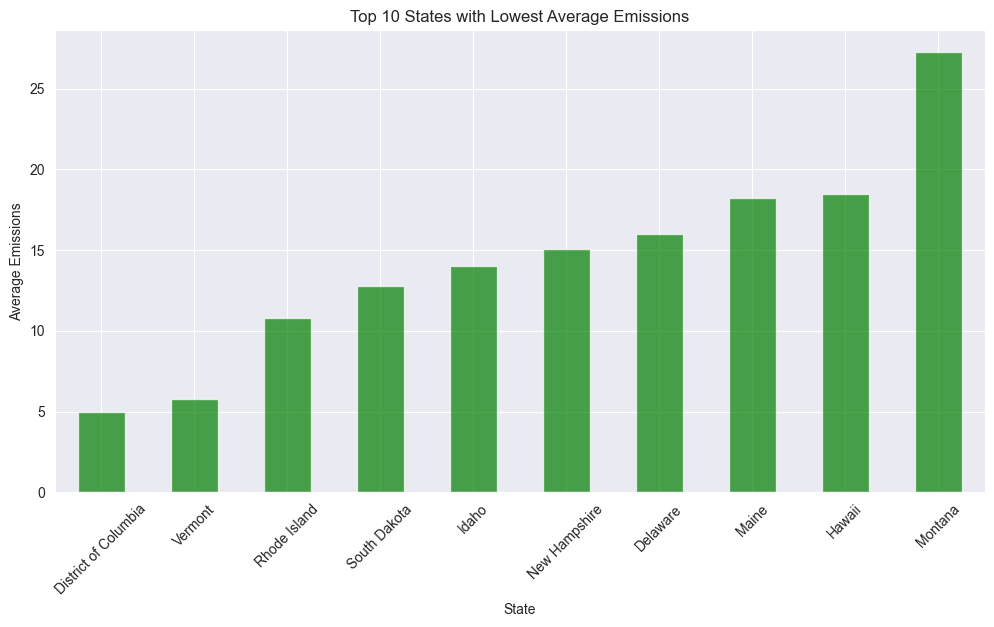

In [5]:
state_emissions_data = state_emissions_data[~state_emissions_data['State'].str.contains("Total", case=False, na=False)]
year_columns = [col for col in state_emissions_data.columns if isinstance(col, int)]
top_states = state_emissions_data.set_index('State')[year_columns].mean(axis=1).nlargest(10)
bottom_states = state_emissions_data.set_index('State')[year_columns].mean(axis=1).nsmallest(10)

plt.figure(figsize=(12, 6))
top_states.plot(kind='bar', color='red', alpha=0.7)
plt.title("Top 10 States with Highest Average Emissions")
plt.xlabel("State")
plt.ylabel("Average Emissions")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 6))
bottom_states.plot(kind='bar', color='green', alpha=0.7)
plt.title("Top 10 States with Lowest Average Emissions")
plt.xlabel("State")
plt.ylabel("Average Emissions")
plt.xticks(rotation=45)
plt.show()

This code analyzes and visualizes emissions data alongside political scores for U.S. states. It first filters out rows containing "Total" in the state name and then identifies the top and bottom 10 states based on their average emissions over time. For each of these states, it detects local minima and maxima in emissions using the `argrelextrema` function. It then plots emissions data over time, marking the local extrema points with blue (minima) and red (maxima) markers, while displaying corresponding political scores at each point. The `plot_emissions_with_extrema` function is used to generate two separate plots: one for the top 10 states with the highest emissions and another for the bottom 10 states with the lowest emissions. Additionally, the `extract_state_name` function extracts the state name from a given directory path. This comprehensive analysis helps in understanding the trends in emissions in relation to political scores over time.

In [6]:
def extract_state_name(base_directory):
    return os.path.basename(base_directory)

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import argrelextrema

def analyze_and_plot_emissions(state_emissions_data, political_scores_data):
    # Remove rows that contain non-state information (like metadata or NaNs)
    state_emissions_data = state_emissions_data[~state_emissions_data['State'].str.contains("Total", case=False, na=False)]
    state_emissions_data = state_emissions_data[~state_emissions_data['State'].isna()]

    # Remove metadata rows that are not actual state names
    state_emissions_data = state_emissions_data[~state_emissions_data['State'].str.contains("Source:", na=False)]

    year_columns = [col for col in state_emissions_data.columns if isinstance(col, int)]

    # Get the top and bottom states based on average emissions over time
    top_states = state_emissions_data.set_index('State')[year_columns].mean(axis=1).nlargest(5).index
    bottom_states = state_emissions_data.set_index('State')[year_columns].mean(axis=1).nsmallest(5).index

    # Filter data for the top and bottom states
    top_states_data = state_emissions_data[state_emissions_data['State'].isin(top_states)].set_index('State')[year_columns].T
    bottom_states_data = state_emissions_data[state_emissions_data['State'].isin(bottom_states)].set_index('State')[year_columns].T

    def find_local_extrema(data):
        extrema = {}
        for state in data.columns:
            emissions = data[state].values
            years = data.index.values
            local_min_idx = argrelextrema(emissions, np.less)[0]  # Indices of local minima
            local_max_idx = argrelextrema(emissions, np.greater)[0]  # Indices of local maxima
            extrema[state] = {
                "min": [(years[i], emissions[i]) for i in local_min_idx],  # Store (year, emission) pairs for mins
                "max": [(years[i], emissions[i]) for i in local_max_idx]   # Store (year, emission) pairs for max
            }
        return extrema

    top_extrema = find_local_extrema(top_states_data)
    bottom_extrema = find_local_extrema(bottom_states_data)

    def plot_emissions_with_extrema(data, extrema, title, scores_data):
        plt.figure(figsize=(12, 6))

        for state in data.columns:
            plt.plot(data.index, data[state], label=state)

            # Plot all local minima
            for x, y in extrema[state]["min"]:
                plt.scatter(x, y, color='blue', marker='v', zorder=5)
                # Convert both state names to uppercase for comparison
                score = scores_data[(scores_data['state'].str.upper() == state.upper()) & (scores_data['year'] == x)]['party_affiliation_score'].values
                if len(score) > 0:
                    # Display the Min label with party affiliation score
                    plt.text(x, y - 0.2, f"Min {score[0]:.2f}", fontsize=9, verticalalignment='bottom', horizontalalignment='center')

            # Plot all local maxima
            for x, y in extrema[state]["max"]:
                plt.scatter(x, y, color='red', marker='^', zorder=5)
                # Convert both state names to uppercase for comparison
                score = scores_data[(scores_data['state'].str.upper() == state.upper()) & (scores_data['year'] == x)]['party_affiliation_score'].values
                if len(score) > 0:
                    # Display the Max label with party affiliation score
                    plt.text(x, y + 0.2, f"Max {score[0]:.2f}", fontsize=9, verticalalignment='top', horizontalalignment='center')

        plt.title(title)
        plt.xlabel("Year")
        plt.ylabel("Emissions")
        plt.legend(title="States", bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside the plot
        plt.grid(True)
        plt.tight_layout()  # To ensure everything fits well without overlap
        plt.show()

    # Run the plot functions
    plot_emissions_with_extrema(top_states_data, top_extrema, "Top 5 States with Highest Emissions Over Time", political_scores_data)
    plot_emissions_with_extrema(bottom_states_data, bottom_extrema, "Top 5 States with Lowest Emissions Over Time", political_scores_data)


In [8]:
state_emissions_data

,State,1970,1971,1972,1973,1974,1975,1976,1977,1978,...,2017,2018,2019,2020,2021,2022,Percent,Absolute,Percent.1,Absolute.1
0,Alabama,102.717308,98.516403,104.984789,109.618074,108.831948,107.827892,108.123429,111.715385,106.665665,...,108.072106,111.907375,105.831211,97.977476,108.309051,109.291123,0.063999,6.573815,0.009067,0.982072
1,Alaska,11.358988,12.646215,13.435356,12.506009,12.793869,14.545277,15.991448,17.984787,19.530629,...,33.612044,34.392556,34.157534,35.915884,39.706281,41.304340,2.636269,29.945353,0.040247,1.598060
2,Arizona,24.937739,27.031606,30.257542,34.484241,36.772653,38.248535,43.806707,50.528150,49.310167,...,90.006330,93.647656,92.112163,79.678622,82.631087,81.426926,2.265209,56.489187,-0.014573,-1.204162
3,Arkansas,36.238491,35.147374,37.246511,40.904539,39.181082,36.417068,38.914652,41.698087,42.461084,...,63.822742,70.451214,64.778837,54.420762,61.727600,63.182542,0.743520,26.944050,0.023570,1.454942
4,California,294.672829,306.128867,313.001675,329.536275,304.727911,311.714448,327.104137,354.674419,345.358928,...,354.472039,356.680792,356.513198,301.963000,324.079546,326.205361,0.107009,31.532531,0.006560,2.125815
5,Colorado,43.057661,43.628581,47.509428,51.112474,50.519445,51.833807,55.165689,58.339998,58.471686,...,88.166320,89.412318,91.099265,79.264087,84.663258,88.685173,1.059684,45.627512,0.047505,4.021915
6,Connecticut,47.839723,45.901611,47.222932,48.585809,45.433967,41.695952,43.441472,43.059846,43.977977,...,33.707466,37.239556,36.494940,33.652811,36.331574,37.041873,-0.225709,-10.797851,0.019550,0.710299
7,Delaware,16.051567,15.907361,15.991638,17.221577,16.636428,15.518162,16.131819,16.116363,16.162534,...,13.712744,13.932115,13.540875,12.158646,12.659583,12.664988,-0.210981,-3.386579,0.000427,0.005405
8,District of Columbia,13.642245,11.877348,11.306110,11.850583,9.849625,7.890092,7.690561,7.922985,7.450558,...,2.578868,2.851156,2.799149,2.393873,2.581308,2.645821,-0.806057,-10.996424,0.024992,0.064513
9,Florida,104.403707,111.555148,121.728053,132.294566,124.346429,125.987894,134.577618,138.240436,146.157945,...,237.368371,240.946920,232.630532,206.725204,225.411105,231.001254,1.212577,126.597547,0.024800,5.590150


In [9]:
final_political_scores_by_year

,state,year,party_affiliation_score
0,ARIZONA,1976,-0.276792
1,CALIFORNIA,1976,0.787895
2,CONNECTICUT,1976,0.701563
3,DELAWARE,1976,0.269130
4,FLORIDA,1976,-0.464138
...,...,...,...
578,VIRGINIA,2020,-0.162847
579,WASHINGTON,2020,0.024978
580,WEST VIRGINIA,2020,-0.181551
581,WISCONSIN,2020,-0.268129


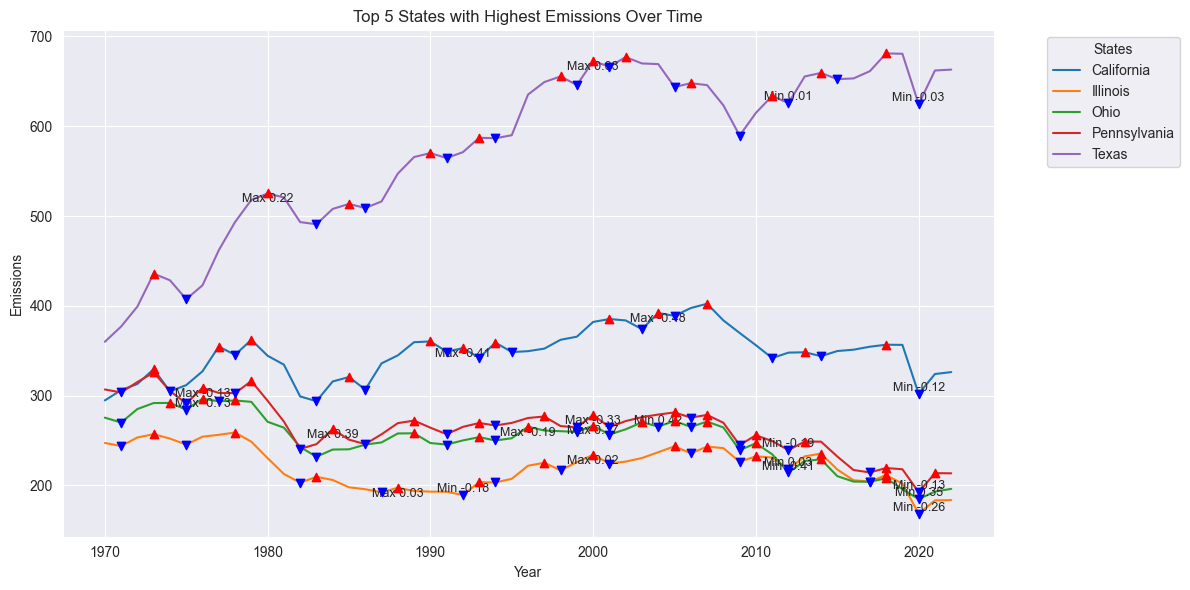

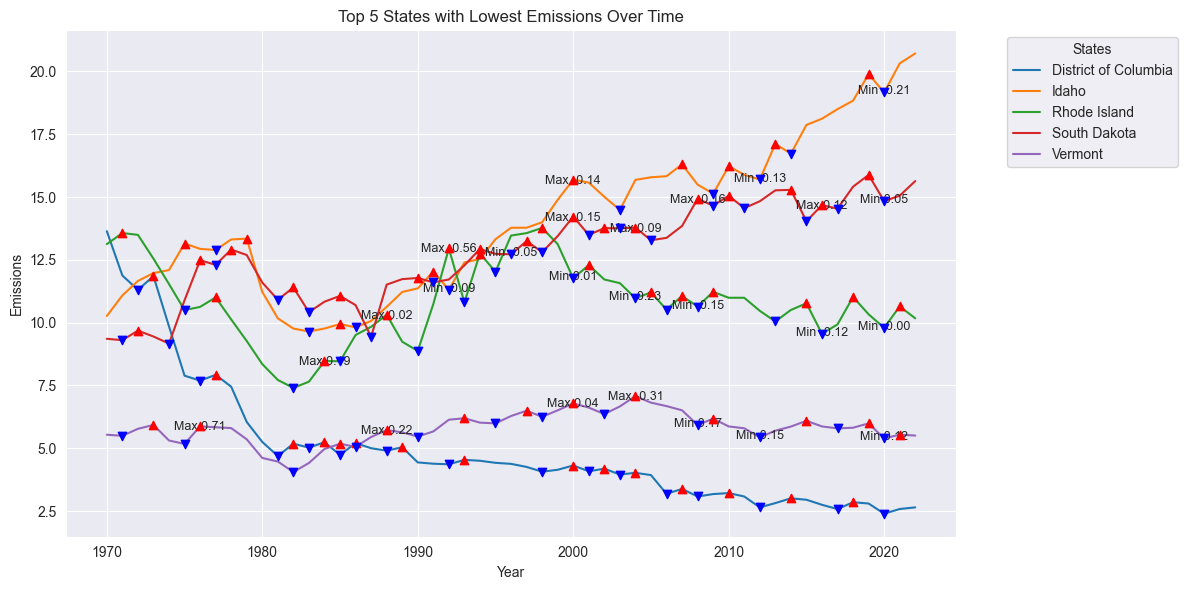

In [10]:
analyze_and_plot_emissions(state_emissions_data, final_political_scores_by_year)

### Demographic and Size Additions

This code performs data transformation and merging to create a comprehensive dataset for analysis. It starts by melting the `state_emissions_data` to reshape it, converting column names to lowercase and standardizing state names using a dictionary (`state_abbreviation_dict`). It then filters the data to include only valid years and merges it with `state_population_size_data` based on state and year. The `state_land_size_data` is also processed and merged to include land size information. Afterward, the political score data (`final_political_scores_by_year`) is integrated into the dataset by standardizing state names and performing another merge. The final result is a merged dataset (`final_merged_dataset`) containing emissions, population size, land size, and political scores for each state and year, ready for further analysis.

In [11]:
state_emissions_melted = state_emissions_data.melt(id_vars=["State"],
                                                   var_name="Year",
                                                   value_name="Emissions")
state_emissions_melted.columns = state_emissions_melted.columns.str.lower()
state_emissions_melted = state_emissions_melted.applymap(lambda x: x.lower() if isinstance(x, str) else x)

state_emissions_melted["state"] = state_emissions_melted["state"].map(state_abbreviation_dict)

state_emissions_melted["year"] = state_emissions_melted["year"].astype(str)
state_emissions_melted = state_emissions_melted.dropna(subset=["year"])  # Remove NaNs
state_emissions_melted = state_emissions_melted[state_emissions_melted["year"].str.isnumeric()]  # Keep only numeric years

state_emissions_melted["year"] = state_emissions_melted["year"].astype(int)
state_population_size_data["year"] = state_population_size_data["year"].astype(int)

merged_population_and_emission_data = state_emissions_melted.merge(state_population_size_data, on=["state", "year"], how="inner")

state_land_size_data = state_land_size_data.rename(columns={"State": "state"})
state_land_size_data["state"] = state_land_size_data["state"].str.lower().map(state_abbreviation_dict)

merged_size_population_emissions_data = merged_population_and_emission_data.merge(state_land_size_data, on="state", how="inner")
merged_size_population_emissions_data = merged_size_population_emissions_data.rename(columns={"Size (Square Miles)": "size"})

final_political_scores_by_year["state"] = final_political_scores_by_year["state"].str.lower().map(state_abbreviation_dict)

final_merged_dataset = merged_size_population_emissions_data.merge(final_political_scores_by_year, on=["state", "year"], how="inner")

final_merged_dataset

,state,year,emissions,population,size,party_affiliation_score
0,AL,1980,107.172609,3900368,52420,0.707140
1,AL,1984,95.389801,3951820,52420,0.365180
2,AL,1988,105.221571,4023844,52420,0.121370
3,AL,1992,120.975301,4139269,52420,0.225649
4,AL,1996,137.217372,4290403,52420,0.015759
...,...,...,...,...,...,...
578,WY,2004,64.383683,509106,97813,-0.206691
579,WY,2008,67.222540,546043,97813,-0.211750
580,WY,2012,66.647098,576656,97813,-0.260097
581,WY,2016,61.035090,585243,97813,-0.280461


### Bills Analysis

This code processes environmental bills and votes data across multiple directories to calculate a "Final Score" for each state and year. It begins by loading JSON files for bills and votes, normalizing and merging the data, and calculating the percentage of "yes" votes for each bill. The code identifies climate-related bills by checking for specific environmental terms in the bill description, calculates a weighted climate score based on vote percentages, and sums these scores to get the final score. The code is designed to process files for all states and years in a directory structure, aggregating the results into a final DataFrame. It also measures the execution time and saves the results to a CSV file. The final output provides a dataset of average "Final Scores" by year and state, reflecting the states' environmental legislative activity over time.

In [12]:
def process_bills_and_votes(bill_directory, vote_directory, environmental_terms):
    def load_json_files_from_directory(directory_path):
        data_list = []
        if os.path.exists(directory_path) and os.listdir(directory_path):
            for filename in os.listdir(directory_path):
                if filename.endswith(".json"):
                    with open(os.path.join(directory_path, filename), 'r') as file:
                        data = json.load(file)
                        df = pd.json_normalize(data)
                        data_list.append(df)
            return pd.concat(data_list, ignore_index=True) if data_list else pd.DataFrame()
        return pd.DataFrame()

    bill_df = load_json_files_from_directory(bill_directory)
    if bill_df.empty:
        return 0

    bill_df.columns = [col.split('.')[-1] for col in bill_df.columns]

    vote_df = load_json_files_from_directory(vote_directory)
    if vote_df.empty:
        return 0

    vote_df.columns = [col.split('.')[-1] for col in vote_df.columns]

    merged_df = pd.merge(bill_df, vote_df, on="bill_id", how="outer")
    merged_df = merged_df.drop_duplicates(subset='bill_id', keep='first')
    merged_df['percent_yes'] = merged_df['yea'] / merged_df['total']
    merged_df = merged_df[['percent_yes', 'bill_id', 'title', 'description']].reset_index().drop(columns=['index'])

    merged_df['climate'] = merged_df['description'].apply(lambda x: 1 if any(term.lower() in str(x).lower() for term in environmental_terms) else 0)
    merged_df.fillna(0)

    climate_ratio = merged_df['climate'].sum() / len(merged_df) if len(merged_df) > 0 else 0
    merged_df['weighted_climate'] = climate_ratio * merged_df['percent_yes']
    final_score = merged_df['weighted_climate'].sum()

    return final_score

def process_all_files(base_directory, environmental_terms):
    year = os.path.basename(base_directory).split('-')[0]
    file_dict = {}

    vote_dir = os.path.join(base_directory, 'vote')
    bill_dir = os.path.join(base_directory, 'bill')

    file_dict[year] = process_bills_and_votes(bill_dir, vote_dir, environmental_terms)

    df = pd.DataFrame(list(file_dict.items()), columns=['Year', 'Final_Score'])
    return df

def process_all_states(base_directory, environmental_terms):
    results = []
    for subdir in os.listdir(base_directory):
        subdir_path = os.path.join(base_directory, subdir)
        print(subdir_path)
        if os.path.isdir(subdir_path):
            subdirectory_df = process_all_files(subdir_path, environmental_terms)
            results.append(subdirectory_df)

    state = extract_state_name(base_directory)
    final_df = pd.concat(results, ignore_index=True)
    final_df['State'] = state
    return final_df

def process_all_directories(base_directory, environmental_terms):
    all_results = []
    state_count = 1

    for state_dir in os.listdir(base_directory):
        print(f"{state_count}: Processing state: {state_dir}")
        state_count+=1
        state_dir_path = os.path.join(base_directory, state_dir)

        if os.path.isdir(state_dir_path):
            state_df = process_all_states(state_dir_path, environmental_terms)
            all_results.append(state_df)

    final_df = pd.concat(all_results, ignore_index=True)
    final_df = final_df.sort_values('Year').reset_index().drop(columns=['index'])
    final_df = final_df.groupby(['Year', 'State'])['Final_Score'].mean().reset_index()

    return final_df

def process_all_directories_timed(base_directory, environmental_terms):
    start_time = time.time()

    results_df = process_all_directories(base_directory, environmental_terms)

    end_time = time.time()
    execution_time = end_time - start_time
    results_df.to_csv('data/results/election_scores.csv')
    print(f"Execution Time: {execution_time} seconds")

    return results_df

In [13]:
# DON'T RUN - TAKES HOURS TO TERMINATE
# results_df = process_all_directories_timed('data/bills', environmental_terms)
# results_df

This code processes the election scores data by reading a CSV file and cleaning the data by removing unnecessary columns and sorting by year and state. It then maps state abbreviations using a dictionary (`state_abbreviation_dict`). The data is grouped into four-year periods (starting from 2008), and the policy scores for each state are aggregated by summing the "Final_Score" within each year group. The resulting DataFrame is renamed to "Policy Scores" and contains aggregated scores by year group and state.

In [14]:
election_scores_df = pd.read_csv('data/results/election_scores.csv')
election_scores_df = election_scores_df.drop(columns=['Unnamed: 0'])
election_scores_df = election_scores_df.sort_values(by=['Year', 'State'], ascending=True)
election_scores_df['State'] = election_scores_df['State'].map(state_abbreviation_dict)

start_year = 2008
election_scores_df['Year_Group'] = (election_scores_df['Year'] - start_year) // 4 * 4 + start_year
aggregated_scores_df = election_scores_df.groupby(['Year_Group', 'State'], as_index=False)['Final_Score'].sum()
aggregated_scores_df = aggregated_scores_df.rename(columns={'Final_Score': 'Policy Scores'})
aggregated_scores_df

,Year_Group,State,Policy Scores
0,2004,OH,0.000000
1,2004,PA,0.000000
2,2008,AK,0.000000
3,2008,AL,1.972585
4,2008,AR,23.282568
...,...,...,...
163,2024,TN,11.959624
164,2024,UT,1.664631
165,2024,VT,0.018692
166,2024,WA,14.846776


This code merges the `aggregated_scores_df` with `final_merged_dataset` based on matching year groups and states, using a right join to ensure all records from `final_merged_dataset` are included. It then drops the columns "State" and "Year_Group" and resets the index, cleaning up the final DataFrame. The resulting `final_df` contains the combined data with the aggregated policy scores and corresponding values from the merged dataset.

In [15]:
final_df = aggregated_scores_df.merge(final_merged_dataset,
                                       left_on=['Year_Group', 'State'],
                                       right_on=['year', 'state'],
                                       how='right')
final_df = final_df.drop(columns=['State', 'Year_Group']).reset_index().drop(columns='index')
final_df

,Policy Scores,state,year,emissions,population,size,party_affiliation_score
0,NaN,AL,1980,107.172609,3900368,52420,0.707140
1,NaN,AL,1984,95.389801,3951820,52420,0.365180
2,NaN,AL,1988,105.221571,4023844,52420,0.121370
3,NaN,AL,1992,120.975301,4139269,52420,0.225649
4,NaN,AL,1996,137.217372,4290403,52420,0.015759
...,...,...,...,...,...,...,...
578,NaN,WY,2004,64.383683,509106,97813,-0.206691
579,3.146390,WY,2008,67.222540,546043,97813,-0.211750
580,14.832834,WY,2012,66.647098,576656,97813,-0.260097
581,12.360478,WY,2016,61.035090,585243,97813,-0.280461


This code identifies the numerical and categorical columns in the `final_df` DataFrame by selecting columns with `float64` and `int64` data types for numerical columns, and excluding them for categorical columns. It then applies a K-Nearest Neighbors (KNN) imputer to fill any missing values in the numerical columns, using 5 neighbors to estimate the missing data. The imputed values are applied to a copy of `final_df`, resulting in a new DataFrame (`final_df_imputed`) with the missing numerical data filled in.

In [16]:
numerical_columns = final_df.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = final_df.select_dtypes(exclude=['float64', 'int64']).columns

imputer = KNNImputer(n_neighbors=5)

final_df_imputed = final_df.copy()
final_df_imputed[numerical_columns] = imputer.fit_transform(final_df_imputed[numerical_columns])

final_df_dropped = final_df.dropna(axis=0)

final_df_imputed, final_df_dropped

(     Policy Scores state    year   emissions  population     size  \
 0        27.000440    AL  1980.0  107.172609   3900368.0  52420.0   
 1        42.097413    AL  1984.0   95.389801   3951820.0  52420.0   
 2        42.097413    AL  1988.0  105.221571   4023844.0  52420.0   
 3        27.183586    AL  1992.0  120.975301   4139269.0  52420.0   
 4        17.721870    AL  1996.0  137.217372   4290403.0  52420.0   
 ..             ...   ...     ...         ...         ...      ...   
 578       7.146112    WY  2004.0   64.383683    509106.0  97813.0   
 579       3.146390    WY  2008.0   67.222540    546043.0  97813.0   
 580      14.832834    WY  2012.0   66.647098    576656.0  97813.0   
 581      12.360478    WY  2016.0   61.035090    585243.0  97813.0   
 582       5.390857    WY  2020.0   55.385165    577681.0  97813.0   
 
      party_affiliation_score  
 0                   0.707140  
 1                   0.365180  
 2                   0.121370  
 3                   0.225649 

#### Prepare Full Data

This code creates a copy of the `final_df_imputed` DataFrame and applies standardization to the selected columns. It first identifies the columns to normalize by excluding "state," "year," and "emissions" from the list of columns. Then, it uses the `StandardScaler` from `sklearn.preprocessing` to normalize these columns, transforming them to have a mean of 0 and a standard deviation of 1. The transformed data is assigned back to the corresponding columns in the `final_df_imputed` DataFrame, resulting in the normalized dataset.

In [17]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

def normalize_data(df, exclude_columns=["state", "year", "emissions", "party_affiliation_score"]):
    scaler = StandardScaler()
    columns_to_normalize = [col for col in df.columns if col not in exclude_columns]
    df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])
    return df

final_df_imputed_normalized = normalize_data(final_df_imputed)
final_df_dropped_normalized = normalize_data(final_df_dropped)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


In [18]:
final_df_imputed_normalized

,Policy Scores,state,year,emissions,population,size,party_affiliation_score
0,0.352368,AL,1980.0,107.172609,-0.267936,-0.242253,0.707140
1,1.003895,AL,1984.0,95.389801,-0.259541,-0.242253,0.365180
2,1.003895,AL,1988.0,105.221571,-0.247790,-0.242253,0.121370
3,0.360271,AL,1992.0,120.975301,-0.228956,-0.242253,0.225649
4,-0.048060,AL,1996.0,137.217372,-0.204297,-0.242253,0.015759
...,...,...,...,...,...,...,...
578,-0.504469,WY,2004.0,64.383683,-0.821263,0.237924,-0.206691
579,-0.677082,WY,2008.0,67.222540,-0.815236,0.237924,-0.211750
580,-0.172740,WY,2012.0,66.647098,-0.810241,0.237924,-0.260097
581,-0.279437,WY,2016.0,61.035090,-0.808840,0.237924,-0.280461


In [19]:
final_df_dropped_normalized

,Policy Scores,state,year,emissions,population,size,party_affiliation_score
7,-0.591852,AL,2008,139.355377,-0.253991,-0.291223,-0.108467
8,-0.348172,AL,2012,122.438181,-0.241008,-0.291223,0.056473
9,-0.371604,AL,2016,113.418599,-0.234388,-0.291223,-0.118678
10,-0.509521,AL,2020,97.977476,-0.212456,-0.291223,-0.215275
18,-0.643880,AK,2008,39.079214,-0.785657,5.264592,0.072105
...,...,...,...,...,...,...,...
570,-0.527898,WI,2020,86.643133,-0.098456,-0.172704,-0.268129
579,-0.560893,WY,2008,67.222540,-0.804310,0.120212,-0.211750
580,-0.252659,WY,2012,66.647098,-0.800272,0.120212,-0.260097
581,-0.317868,WY,2016,61.035090,-0.799139,0.120212,-0.280461


In [20]:
final_df_dropped_normalized = pd.get_dummies(final_df_dropped_normalized, columns=['state'])
final_df_dropped_normalized

,Policy Scores,year,emissions,population,size,party_affiliation_score,state_AK,state_AL,state_AR,state_AZ,...,state_OR,state_PA,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WY
7,-0.591852,2008,139.355377,-0.253991,-0.291223,-0.108467,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8,-0.348172,2012,122.438181,-0.241008,-0.291223,0.056473,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9,-0.371604,2016,113.418599,-0.234388,-0.291223,-0.118678,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
10,-0.509521,2020,97.977476,-0.212456,-0.291223,-0.215275,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
18,-0.643880,2008,39.079214,-0.785657,5.264592,0.072105,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
570,-0.527898,2020,86.643133,-0.098456,-0.172704,-0.268129,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
579,-0.560893,2008,67.222540,-0.804310,0.120212,-0.211750,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
580,-0.252659,2012,66.647098,-0.800272,0.120212,-0.260097,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
581,-0.317868,2016,61.035090,-0.799139,0.120212,-0.280461,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [21]:
final_df_imputed_normalized = pd.get_dummies(final_df_imputed_normalized, columns=['state'])
final_df_imputed_normalized

,Policy Scores,year,emissions,population,size,party_affiliation_score,state_AK,state_AL,state_AR,state_AZ,...,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
0,0.352368,1980.0,107.172609,-0.267936,-0.242253,0.707140,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.003895,1984.0,95.389801,-0.259541,-0.242253,0.365180,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.003895,1988.0,105.221571,-0.247790,-0.242253,0.121370,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.360271,1992.0,120.975301,-0.228956,-0.242253,0.225649,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-0.048060,1996.0,137.217372,-0.204297,-0.242253,0.015759,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578,-0.504469,2004.0,64.383683,-0.821263,0.237924,-0.206691,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
579,-0.677082,2008.0,67.222540,-0.815236,0.237924,-0.211750,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
580,-0.172740,2012.0,66.647098,-0.810241,0.237924,-0.260097,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
581,-0.279437,2016.0,61.035090,-0.808840,0.237924,-0.280461,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


This code applies one-hot encoding to the "state" column in the `final_df_imputed` DataFrame using the `pd.get_dummies()` function. This transforms the categorical "state" column into multiple binary (0 or 1) columns, each representing a different state. The resulting `final_df_imputed` DataFrame contains the original data along with the new binary columns for each state. Each column indicates whether the data corresponds to a specific state, allowing for easier inclusion in machine learning models.

## Final Analysis

### Current Emissions Predictions

This code trains a Random Forest model to predict emissions using various features such as "Policy Scores," "population," "size," "party_affiliation_score," and state-specific columns. It splits the data into training and testing sets, trains the model, and makes predictions on the test set. The Mean Squared Error (MSE) is calculated to evaluate the model's performance, and the execution time of the process is also recorded and printed. The final output includes the MSE and the time taken to train and test the model.

In [22]:
def train_rf_model(df, exclude_columns=["state", "year", "emissions", "party_affiliation_score"]):
    label_encoder = LabelEncoder()
    df['political_party'] = label_encoder.fit_transform(df['party_affiliation_score'])

    state_columns = df.columns[6:]
    X = df[['Policy Scores', 'population', 'size', 'party_affiliation_score'] + list(state_columns)]
    y = df['emissions']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    start_time = time.time()
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    y_pred = rf_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    elapsed_time = time.time() - start_time

    feature_importance = rf_model.feature_importances_
    features = X.columns
    feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    print(f'Mean Squared Error: {mse}')
    print(f'R² Score: {r2}')
    print(f'Time taken: {elapsed_time} seconds')

    print("\nFeature Importance:")
    print(feature_importance_df)

    return mse, r2, elapsed_time, feature_importance_df

#### Imputed

In [23]:
mse_imputed, r2_imputed, elapsed_time_imputed, feature_importance_imputed = train_rf_model(final_df_imputed_normalized)

Mean Squared Error: 338.41073332161824
R² Score: 0.9780304671827261
Time taken: 0.22203397750854492 seconds

Feature Importance:
                    Feature  Importance
1                population    0.742299
2                      size    0.113883
46                 state_TX    0.064666
18                 state_IN    0.016699
21                 state_LA    0.014776
8                  state_CA    0.008940
0             Policy Scores    0.007598
54          political_party    0.005599
3   party_affiliation_score    0.005269
52                 state_WV    0.004248
41                 state_PA    0.001937
20                 state_KY    0.001816
40                 state_OR    0.001621
25                 state_MI    0.001593
39                 state_OK    0.001376
53                 state_WY    0.001015
31                 state_ND    0.000816
51                 state_WI    0.000754
37                 state_NY    0.000575
5                  state_AL    0.000483
44                 state_SD    

#### Non-imputed

In [24]:
mse_dropped, r2_dropped, elapsed_time_dropped, feature_importance_dropped = train_rf_model(final_df_dropped_normalized)

Mean Squared Error: 1299.6382478981864
R² Score: 0.9263587076965067
Time taken: 0.09795713424682617 seconds

Feature Importance:
                    Feature    Importance
1                population  7.841577e-01
2                      size  7.500179e-02
34                 state_TX  6.198352e-02
17                 state_IN  2.408352e-02
41          political_party  1.514810e-02
0             Policy Scores  1.183601e-02
3   party_affiliation_score  1.069785e-02
8                  state_CA  7.623742e-03
30                 state_OK  2.870826e-03
13                 state_GA  1.350398e-03
31                 state_OR  1.314650e-03
16                 state_ID  6.381751e-04
40                 state_WY  6.117979e-04
15                 state_IA  5.346219e-04
20                 state_MA  4.005514e-04
27                 state_NE  2.446387e-04
24                 state_MO  2.343578e-04
19                 state_KY  2.326957e-04
39                 state_WI  1.381095e-04
12                 state_FL  1.

This code trains a Gradient Boosting model to predict emissions using features like "Policy Scores," "population," "size," "party_affiliation_score," and state-specific columns. The data is split into training and testing sets, and the model is trained using the training data. After making predictions on the test set, the Mean Squared Error (MSE) is calculated to evaluate the model's performance, and the execution time for training and testing the model is also recorded and printed. The output includes the MSE and the time taken to complete the process.

In [25]:
def train_gb_model(df, exclude_columns=["state", "year", "emissions", "party_affiliation_score"]):
    state_columns = df.columns[6:]
    columns_to_select = ['Policy Scores', 'population', 'size', 'party_affiliation_score'] + list(state_columns)

    X = df[columns_to_select]
    y = df['emissions']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    start_time = time.time()
    gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
    gb_model.fit(X_train, y_train)

    y_pred = gb_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    elapsed_time = time.time() - start_time

    feature_importance = gb_model.feature_importances_
    features = X.columns
    feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    print(f'Mean Squared Error: {mse}')
    print(f'R² Score: {r2}')
    print(f'Time taken: {elapsed_time} seconds')

    print("\nFeature Importance:")
    print(feature_importance_df)

    return mse, r2, elapsed_time, feature_importance_df

#### Imputed

In [26]:
mse_imputed, r2_imputed, elapsed_time_imputed, feature_importance_imputed = train_gb_model(final_df_imputed_normalized)

Mean Squared Error: 341.75505197235833
R² Score: 0.977813354925004
Time taken: 0.07615113258361816 seconds

Feature Importance:
                    Feature  Importance
1                population    0.725491
2                      size    0.109265
46                 state_TX    0.088298
21                 state_LA    0.016069
18                 state_IN    0.015745
8                  state_CA    0.010325
0             Policy Scores    0.007541
52                 state_WV    0.004910
41                 state_PA    0.004359
20                 state_KY    0.002503
3   party_affiliation_score    0.002450
54          political_party    0.002231
37                 state_NY    0.001803
40                 state_OR    0.001739
53                 state_WY    0.001301
48                 state_VA    0.000851
44                 state_SD    0.000621
50                 state_WA    0.000576
5                  state_AL    0.000570
39                 state_OK    0.000546
16                 state_ID    0

#### Non-imputed

In [27]:
mse_dropped, r2_dropped, elapsed_time_dropped, feature_importance_dropped = train_gb_model(final_df_dropped_normalized)

Mean Squared Error: 640.1066949192801
R² Score: 0.9637296883942843
Time taken: 0.030339956283569336 seconds

Feature Importance:
                    Feature  Importance
1                population    0.860272
2                      size    0.040514
8                  state_CA    0.028319
17                 state_IN    0.023005
34                 state_TX    0.014735
0             Policy Scores    0.011715
41          political_party    0.007535
3   party_affiliation_score    0.003870
30                 state_OK    0.002219
13                 state_GA    0.001757
19                 state_KY    0.001543
16                 state_ID    0.000990
40                 state_WY    0.000908
31                 state_OR    0.000830
39                 state_WI    0.000433
5                  state_AL    0.000287
38                 state_WA    0.000282
24                 state_MO    0.000249
37                 state_VT    0.000187
29                 state_OH    0.000147
18                 state_KS    

### Future Predictions

This code splits the data into 10-year intervals and trains a Random Forest model to predict emissions for each interval. It calculates predictions and compares them with actual emissions, evaluating the model's performance using Mean Squared Error (MSE) and R² score. The actual and predicted emissions are plotted over the years, and the model performance metrics are displayed. The final output is a DataFrame showing the actual and predicted emissions for each year.

In [34]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

def train_random_forest(df, n):
    try:
        if df['year'].dtype == 'object' or df['year'].dtype == 'int64':
            df['year'] = pd.to_datetime(df['year'], errors='coerce')

        state_columns = [col for col in df.columns if col.startswith('state_')]
        if not state_columns:
            print("No state columns found!")
            return

        print(f"State columns: {state_columns}")

        df['state'] = df[state_columns].idxmax(axis=1).str.replace('state_', '', regex=False)
        df = df.sort_values(['state', 'year'])

        df['y_shifted'] = df.groupby('state')['emissions'].shift(-n)
        print(f"Shape after shifting: {df.shape}")

        df = df.dropna(subset=['y_shifted'])
        print(f"Shape after dropping NaNs: {df.shape}")

        if df.shape[0] == 0:
            print("After dropping NaN values, the dataset is empty.")
            return

        features = ['Policy Scores', 'population', 'size', 'party_affiliation_score'] + state_columns
        X = df[features]
        y = df['y_shifted']

        if X.shape[0] == 0:
            print("Features dataset is empty!")
            return

        print(f"Shape of X: {X.shape}, Shape of y: {y.shape}")

        # Perform train-test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        print(f"Shape of X_train: {X_train.shape}, Shape of X_test: {X_test.shape}")
        print(f"Shape of y_train: {y_train.shape}, Shape of y_test: {y_test.shape}")

        if X_train.shape[0] == 0 or X_test.shape[0] == 0:
            print("After train-test split, there are no samples in train or test.")
            return

        # Train RandomForestRegressor
        rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
        rf_model.fit(X_train, y_train)

        print("Model training completed.")

        # Make predictions
        y_pred = rf_model.predict(X_test)

        r2 = r2_score(y_test, y_pred)
        print(f'R² Score: {r2}')

        mse = mean_squared_error(y_test, y_pred)
        print(f'Mean Squared Error: {mse}')

        selected_states = df['state'].unique()[:3]
        plt.figure(figsize=(10, 6))

        for state in selected_states:
            state_data = df[df['state'] == state]
            plt.plot(state_data['year'], state_data['emissions'], label=f'Actual Emissions ({state})', linestyle='--', alpha=0.7)
            plt.plot(state_data['year'], state_data['y_shifted'], label=f'Predicted Emissions ({state})', alpha=0.7)

        plt.xlabel('Year')
        plt.ylabel('Emissions')
        plt.title('Predicted vs Actual Emissions Over Time for 3 States')
        plt.legend(title='State', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

        feature_importances = rf_model.feature_importances_
        for feature, importance in zip(features, feature_importances):
            print(f'Feature: {feature}, Importance: {importance}')

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        print("Debugging details:")
        print(f"DataFrame shape before: {df.shape}")
        print(f"Columns: {df.columns}")
        print(f"n (shift): {n}")


#### Imputed

State columns: ['state_AK', 'state_AL', 'state_AR', 'state_AZ', 'state_CA', 'state_CO', 'state_CT', 'state_DE', 'state_FL', 'state_GA', 'state_HI', 'state_IA', 'state_ID', 'state_IL', 'state_IN', 'state_KS', 'state_KY', 'state_LA', 'state_MA', 'state_MD', 'state_ME', 'state_MI', 'state_MN', 'state_MO', 'state_MS', 'state_MT', 'state_NC', 'state_ND', 'state_NE', 'state_NH', 'state_NJ', 'state_NM', 'state_NV', 'state_NY', 'state_OH', 'state_OK', 'state_OR', 'state_PA', 'state_RI', 'state_SC', 'state_SD', 'state_TN', 'state_TX', 'state_UT', 'state_VA', 'state_VT', 'state_WA', 'state_WI', 'state_WV', 'state_WY']
Shape after shifting: (583, 59)
Shape after dropping NaNs: (533, 59)
Shape of X: (533, 54), Shape of y: (533,)
Shape of X_train: (426, 54), Shape of X_test: (107, 54)
Shape of y_train: (426,), Shape of y_test: (107,)
Model training completed.
R² Score: 0.9789471663132989
Mean Squared Error: 250.4518171189288


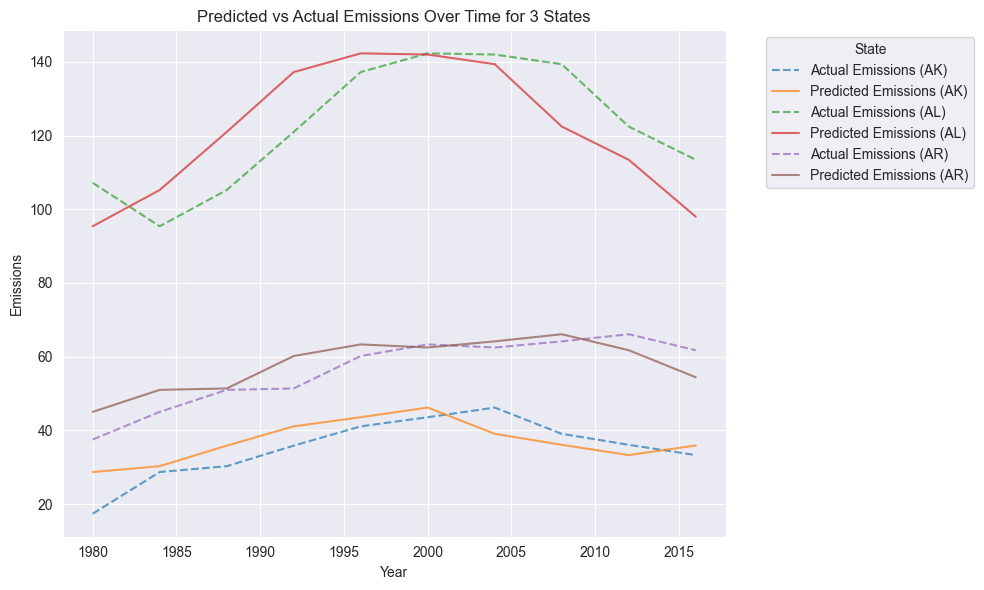

Feature: Policy Scores, Importance: 0.006375472180044912
Feature: population, Importance: 0.6767114401683617
Feature: size, Importance: 0.09979404330156755
Feature: party_affiliation_score, Importance: 0.005902399199719214
Feature: state_AK, Importance: 6.580286423957677e-06
Feature: state_AL, Importance: 0.00020221504120087236
Feature: state_AR, Importance: 1.575633033586567e-05
Feature: state_AZ, Importance: 1.1929452058340374e-05
Feature: state_CA, Importance: 0.007961192073880043
Feature: state_CO, Importance: 3.916522102677008e-05
Feature: state_CT, Importance: 0.00029156219477958367
Feature: state_DE, Importance: 8.021275630476666e-07
Feature: state_FL, Importance: 0.0001108514482766766
Feature: state_GA, Importance: 0.0008845803408903701
Feature: state_HI, Importance: 5.7407259108722586e-06
Feature: state_IA, Importance: 0.0003004168437573973
Feature: state_ID, Importance: 0.00019741269828568508
Feature: state_IL, Importance: 0.00016078874775043178
Feature: state_IN, Importance:

In [35]:
train_random_forest(final_df_imputed_normalized, 1)

State columns: ['state_AK', 'state_AL', 'state_AR', 'state_AZ', 'state_CA', 'state_CO', 'state_CT', 'state_DE', 'state_FL', 'state_GA', 'state_HI', 'state_IA', 'state_ID', 'state_IL', 'state_IN', 'state_KS', 'state_KY', 'state_LA', 'state_MA', 'state_MD', 'state_ME', 'state_MI', 'state_MN', 'state_MO', 'state_MS', 'state_MT', 'state_NC', 'state_ND', 'state_NE', 'state_NH', 'state_NJ', 'state_NM', 'state_NV', 'state_NY', 'state_OH', 'state_OK', 'state_OR', 'state_PA', 'state_RI', 'state_SC', 'state_SD', 'state_TN', 'state_TX', 'state_UT', 'state_VA', 'state_VT', 'state_WA', 'state_WI', 'state_WV', 'state_WY']
Shape after shifting: (583, 59)
Shape after dropping NaNs: (333, 59)
Shape of X: (333, 54), Shape of y: (333,)
Shape of X_train: (266, 54), Shape of X_test: (67, 54)
Shape of y_train: (266,), Shape of y_test: (67,)
Model training completed.
R² Score: 0.9866150858434528
Mean Squared Error: 230.2299060878833


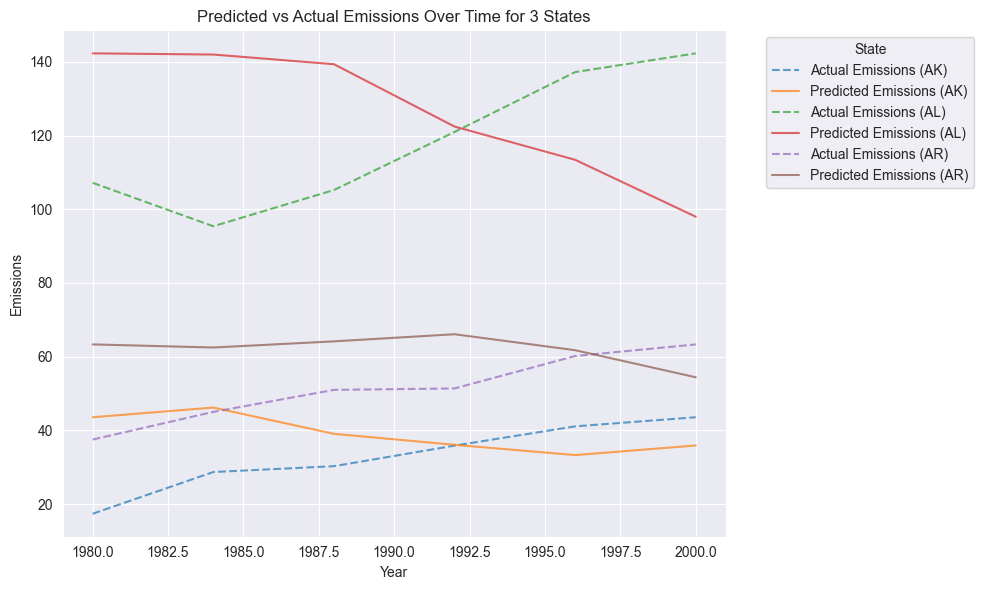

Feature: Policy Scores, Importance: 0.01074692794561401
Feature: population, Importance: 0.657036269187609
Feature: size, Importance: 0.11876174147754825
Feature: party_affiliation_score, Importance: 0.010941489751571649
Feature: state_AK, Importance: 1.3181022982133332e-05
Feature: state_AL, Importance: 6.763724259737049e-05
Feature: state_AR, Importance: 7.960089133101192e-06
Feature: state_AZ, Importance: 0.0003330293722380201
Feature: state_CA, Importance: 0.008987592795377447
Feature: state_CO, Importance: 0.00032067124887084463
Feature: state_CT, Importance: 0.0006453296047101106
Feature: state_DE, Importance: 3.943514933738041e-06
Feature: state_FL, Importance: 0.0012662457410500174
Feature: state_GA, Importance: 0.0009053186647266293
Feature: state_HI, Importance: 7.453447959108355e-06
Feature: state_IA, Importance: 8.245252889249633e-05
Feature: state_ID, Importance: 0.00012358938655230428
Feature: state_IL, Importance: 0.00020504266611044375
Feature: state_IN, Importance: 0.0

In [36]:
train_random_forest(final_df_imputed_normalized, 5)

State columns: ['state_AK', 'state_AL', 'state_AR', 'state_AZ', 'state_CA', 'state_CO', 'state_CT', 'state_DE', 'state_FL', 'state_GA', 'state_HI', 'state_IA', 'state_ID', 'state_IL', 'state_IN', 'state_KS', 'state_KY', 'state_LA', 'state_MA', 'state_MD', 'state_ME', 'state_MI', 'state_MN', 'state_MO', 'state_MS', 'state_MT', 'state_NC', 'state_ND', 'state_NE', 'state_NH', 'state_NJ', 'state_NM', 'state_NV', 'state_NY', 'state_OH', 'state_OK', 'state_OR', 'state_PA', 'state_RI', 'state_SC', 'state_SD', 'state_TN', 'state_TX', 'state_UT', 'state_VA', 'state_VT', 'state_WA', 'state_WI', 'state_WV', 'state_WY']
Shape after shifting: (583, 59)
Shape after dropping NaNs: (83, 59)
Shape of X: (83, 54), Shape of y: (83,)
Shape of X_train: (66, 54), Shape of X_test: (17, 54)
Shape of y_train: (66,), Shape of y_test: (17,)
Model training completed.
R² Score: -1.9839187021096687
Mean Squared Error: 10333.873199453728


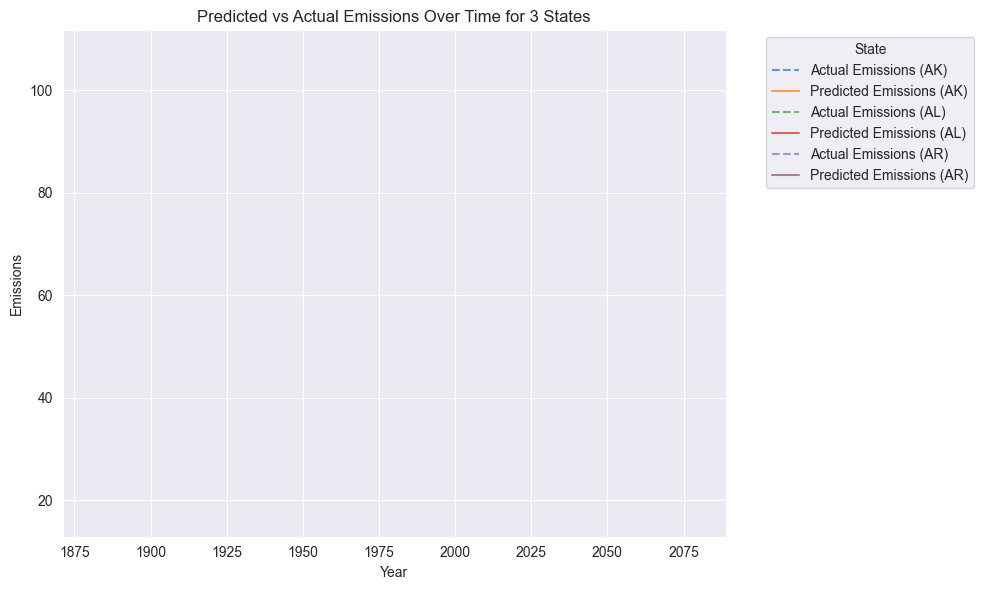

Feature: Policy Scores, Importance: 0.022013247776918803
Feature: population, Importance: 0.2982676206489575
Feature: size, Importance: 0.5743142270420396
Feature: party_affiliation_score, Importance: 0.009196409980916658
Feature: state_AK, Importance: 0.0
Feature: state_AL, Importance: 0.00024812189457399736
Feature: state_AR, Importance: 3.418167495503892e-05
Feature: state_AZ, Importance: 0.0001407095315773605
Feature: state_CA, Importance: 0.011863654799991016
Feature: state_CO, Importance: 4.748298379347274e-05
Feature: state_CT, Importance: 0.0008610821933209922
Feature: state_DE, Importance: 1.576720133577267e-07
Feature: state_FL, Importance: 6.770058090856479e-05
Feature: state_GA, Importance: 0.00018265531171588576
Feature: state_HI, Importance: 1.5088648557853168e-05
Feature: state_IA, Importance: 4.9736426609368165e-05
Feature: state_ID, Importance: 0.0
Feature: state_IL, Importance: 0.0004602735724437499
Feature: state_IN, Importance: 0.010364493098439903
Feature: state_KS

In [37]:
train_random_forest(final_df_imputed_normalized, 10)

#### Non-imputed

State columns: ['state_AK', 'state_AL', 'state_AR', 'state_AZ', 'state_CA', 'state_CO', 'state_CT', 'state_DE', 'state_FL', 'state_GA', 'state_HI', 'state_IA', 'state_ID', 'state_IN', 'state_KS', 'state_KY', 'state_MA', 'state_MD', 'state_ME', 'state_MN', 'state_MO', 'state_MS', 'state_MT', 'state_NE', 'state_NV', 'state_OH', 'state_OK', 'state_OR', 'state_PA', 'state_TN', 'state_TX', 'state_UT', 'state_VA', 'state_VT', 'state_WA', 'state_WI', 'state_WY']
Shape after shifting: (144, 46)
Shape after dropping NaNs: (107, 46)
Shape of X: (107, 41), Shape of y: (107,)
Shape of X_train: (85, 41), Shape of X_test: (22, 41)
Shape of y_train: (85,), Shape of y_test: (22,)
Model training completed.
R² Score: 0.9128646131936858
Mean Squared Error: 403.5206205078664


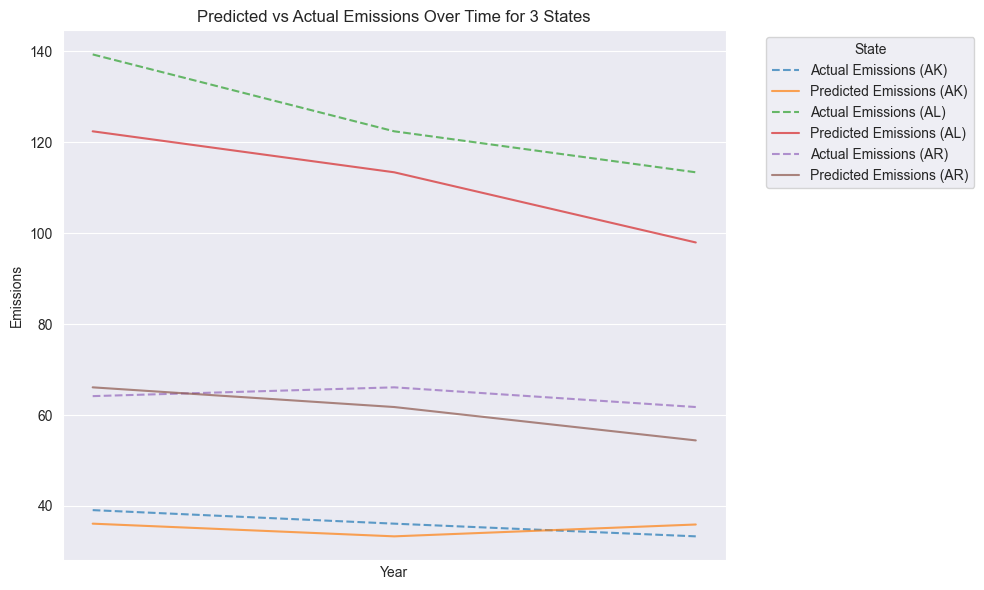

Feature: Policy Scores, Importance: 0.009346254950320564
Feature: population, Importance: 0.6206503807118688
Feature: size, Importance: 0.11710659146397571
Feature: party_affiliation_score, Importance: 0.011945571036651587
Feature: state_AK, Importance: 3.5900254290797254e-06
Feature: state_AL, Importance: 3.0214868953618756e-05
Feature: state_AR, Importance: 1.257150682956971e-05
Feature: state_AZ, Importance: 1.8202301191488216e-05
Feature: state_CA, Importance: 0.004283725908731677
Feature: state_CO, Importance: 1.4415753430350993e-05
Feature: state_CT, Importance: 0.00019266753070020176
Feature: state_DE, Importance: 1.4349750120696333e-06
Feature: state_FL, Importance: 9.585778075914805e-05
Feature: state_GA, Importance: 0.0007093166780796177
Feature: state_HI, Importance: 3.540154326119849e-06
Feature: state_IA, Importance: 0.00014540851634631185
Feature: state_ID, Importance: 0.00036262203922917416
Feature: state_IN, Importance: 0.01693674062836957
Feature: state_KS, Importance:

In [38]:
train_random_forest(final_df_dropped_normalized, 1)

In [41]:
train_random_forest(final_df_dropped_normalized, 5)

State columns: ['state_AK', 'state_AL', 'state_AR', 'state_AZ', 'state_CA', 'state_CO', 'state_CT', 'state_DE', 'state_FL', 'state_GA', 'state_HI', 'state_IA', 'state_ID', 'state_IN', 'state_KS', 'state_KY', 'state_MA', 'state_MD', 'state_ME', 'state_MN', 'state_MO', 'state_MS', 'state_MT', 'state_NE', 'state_NV', 'state_OH', 'state_OK', 'state_OR', 'state_PA', 'state_TN', 'state_TX', 'state_UT', 'state_VA', 'state_VT', 'state_WA', 'state_WI', 'state_WY']
Shape after shifting: (144, 46)
Shape after dropping NaNs: (0, 46)
After dropping NaN values, the dataset is empty.


In [42]:
train_random_forest(final_df_dropped_normalized, 10)

State columns: ['state_AK', 'state_AL', 'state_AR', 'state_AZ', 'state_CA', 'state_CO', 'state_CT', 'state_DE', 'state_FL', 'state_GA', 'state_HI', 'state_IA', 'state_ID', 'state_IN', 'state_KS', 'state_KY', 'state_MA', 'state_MD', 'state_ME', 'state_MN', 'state_MO', 'state_MS', 'state_MT', 'state_NE', 'state_NV', 'state_OH', 'state_OK', 'state_OR', 'state_PA', 'state_TN', 'state_TX', 'state_UT', 'state_VA', 'state_VT', 'state_WA', 'state_WI', 'state_WY']
Shape after shifting: (144, 46)
Shape after dropping NaNs: (0, 46)
After dropping NaN values, the dataset is empty.


### Unsupervised Analysis

This code creates a new column, "political_party," in the `final_df_imputed` DataFrame. It assigns the value 'D' (Democrat) if the "final_score_avg" is greater than 0, and 'R' (Republican) if it is less than or equal to 0. The resulting DataFrame reflects the political party assignment based on the final scores.

In [43]:
final_df_imputed_normalized['political_party'] = final_df_imputed_normalized['party_affiliation_score'].apply(lambda x: 'D' if x > 0 else 'R')
final_df_imputed_normalized

,Policy Scores,year,emissions,population,size,party_affiliation_score,state_AK,state_AL,state_AR,state_AZ,...,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,political_party,state
0,0.352368,1980.0,107.172609,-0.267936,-0.242253,0.707140,0,1,0,0,...,0,0,0,0,0,0,0,0,D,AL
1,1.003895,1984.0,95.389801,-0.259541,-0.242253,0.365180,0,1,0,0,...,0,0,0,0,0,0,0,0,D,AL
2,1.003895,1988.0,105.221571,-0.247790,-0.242253,0.121370,0,1,0,0,...,0,0,0,0,0,0,0,0,D,AL
3,0.360271,1992.0,120.975301,-0.228956,-0.242253,0.225649,0,1,0,0,...,0,0,0,0,0,0,0,0,D,AL
4,-0.048060,1996.0,137.217372,-0.204297,-0.242253,0.015759,0,1,0,0,...,0,0,0,0,0,0,0,0,D,AL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578,-0.504469,2004.0,64.383683,-0.821263,0.237924,-0.206691,0,0,0,0,...,0,0,0,0,0,0,0,1,R,WY
579,-0.677082,2008.0,67.222540,-0.815236,0.237924,-0.211750,0,0,0,0,...,0,0,0,0,0,0,0,1,R,WY
580,-0.172740,2012.0,66.647098,-0.810241,0.237924,-0.260097,0,0,0,0,...,0,0,0,0,0,0,0,1,R,WY
581,-0.279437,2016.0,61.035090,-0.808840,0.237924,-0.280461,0,0,0,0,...,0,0,0,0,0,0,0,1,R,WY


In [44]:
final_df_dropped_normalized['political_party'] = final_df_dropped_normalized['party_affiliation_score'].apply(lambda x: 'D' if x > 0 else 'R')

final_df_dropped_normalized

,Policy Scores,year,emissions,population,size,party_affiliation_score,state_AK,state_AL,state_AR,state_AZ,...,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WY,political_party,state
7,-0.591852,1970-01-01 00:00:00.000002008,139.355377,-0.253991,-0.291223,-0.108467,0,1,0,0,...,0,0,0,0,0,0,0,0,R,AL
8,-0.348172,1970-01-01 00:00:00.000002012,122.438181,-0.241008,-0.291223,0.056473,0,1,0,0,...,0,0,0,0,0,0,0,0,D,AL
9,-0.371604,1970-01-01 00:00:00.000002016,113.418599,-0.234388,-0.291223,-0.118678,0,1,0,0,...,0,0,0,0,0,0,0,0,R,AL
10,-0.509521,1970-01-01 00:00:00.000002020,97.977476,-0.212456,-0.291223,-0.215275,0,1,0,0,...,0,0,0,0,0,0,0,0,R,AL
18,-0.643880,1970-01-01 00:00:00.000002008,39.079214,-0.785657,5.264592,0.072105,1,0,0,0,...,0,0,0,0,0,0,0,0,D,AK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
570,-0.527898,1970-01-01 00:00:00.000002020,86.643133,-0.098456,-0.172704,-0.268129,0,0,0,0,...,0,0,0,0,0,0,1,0,R,WI
579,-0.560893,1970-01-01 00:00:00.000002008,67.222540,-0.804310,0.120212,-0.211750,0,0,0,0,...,0,0,0,0,0,0,0,1,R,WY
580,-0.252659,1970-01-01 00:00:00.000002012,66.647098,-0.800272,0.120212,-0.260097,0,0,0,0,...,0,0,0,0,0,0,0,1,R,WY
581,-0.317868,1970-01-01 00:00:00.000002016,61.035090,-0.799139,0.120212,-0.280461,0,0,0,0,...,0,0,0,0,0,0,0,1,R,WY


This code processes the data by assigning political party labels based on the `party_affiliation_score` and then performs Principal Component Analysis (PCA) to reduce the data to two components, visualizing the results in a scatter plot with political party color coding. It then trains a Support Vector Machine (SVM) classifier using the two PCA components to predict political party affiliation, evaluating the model with accuracy and a confusion matrix, and visualizing the confusion matrix with a heatmap. Additionally, the code calculates and visualizes the correlation matrix for selected features to assess their relationships and calculates the Variance Inflation Factor (VIF) to check for multicollinearity among the features, providing insights into potential issues in the dataset.

In [45]:
def analyze_political_party(df):
    if 'party_affiliation_score' not in df.columns:
        df['party_affiliation_score'] = 0

    X = df[['Policy Scores', 'population', 'size', 'party_affiliation_score']]
    X_scaled = StandardScaler().fit_transform(X)

    pca_result = PCA(n_components=2).fit_transform(X_scaled)
    pca_df = pd.DataFrame(data=pca_result, columns=['PCA1', 'PCA2'])
    pca_df['political_party'] = df['political_party']
    pca_df['party_affiliation_score'] = df['party_affiliation_score']

    pca_df['political_party'] = pca_df['political_party'].fillna(
        pca_df['party_affiliation_score'].apply(lambda x: 'D' if x > 0 else 'R')
    )

    plt.figure(figsize=(10, 6))
    colors = {'D': 'blue', 'R': 'red'}
    plt.scatter(pca_df['PCA1'], pca_df['PCA2'], c=pca_df['political_party'].apply(lambda x: colors[x]), alpha=0.7)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA of Political Parties')
    plt.grid(True)
    plt.legend(['Democrat', 'Republican'])
    plt.show()

    X_pca = pca_df[['PCA1', 'PCA2']]
    y = pca_df['political_party']

    pca_df = pca_df.dropna(subset=['political_party'])

    X_pca = pca_df[['PCA1', 'PCA2']]
    y = pca_df['political_party']

    svm_model = SVC(kernel='linear', random_state=42)
    svm_model.fit(X_pca, y)

    y_pred = svm_model.predict(X_pca)

    accuracy = accuracy_score(y, y_pred)
    cm = confusion_matrix(y, y_pred)

    print(f'Accuracy: {accuracy}')
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Democrat', 'Republican'], yticklabels=['Democrat', 'Republican'])
    plt.title('Confusion Matrix')
    plt.show()

    correlation_matrix = df[['Policy Scores', 'population', 'size', 'party_affiliation_score']].corr()

    plt.figure(figsize=(10, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Correlation Matrix')
    plt.show()

    X_with_const = add_constant(X)
    vif_data = pd.DataFrame()
    vif_data['Feature'] = X_with_const.columns
    vif_data['VIF'] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]

    print(vif_data)


#### Imputed

In [46]:
without_party_score_df = final_df_imputed_normalized.drop(columns='party_affiliation_score')

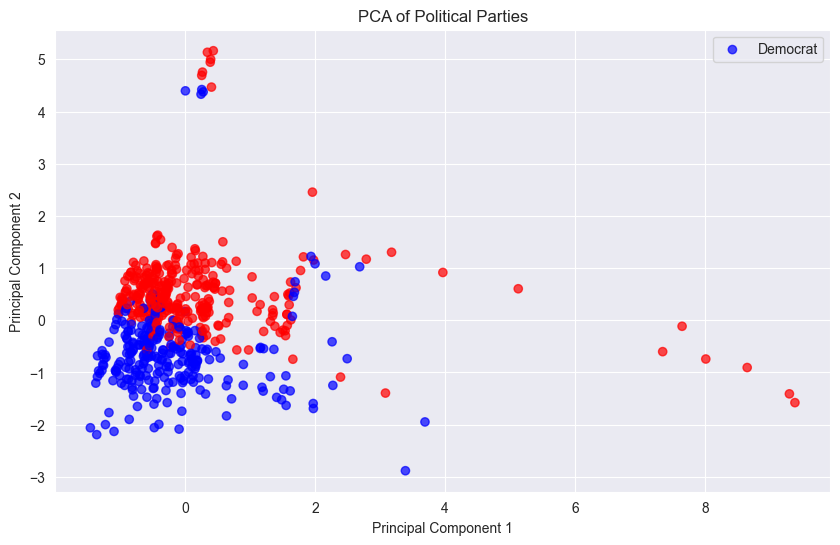

Accuracy: 0.8987993138936535


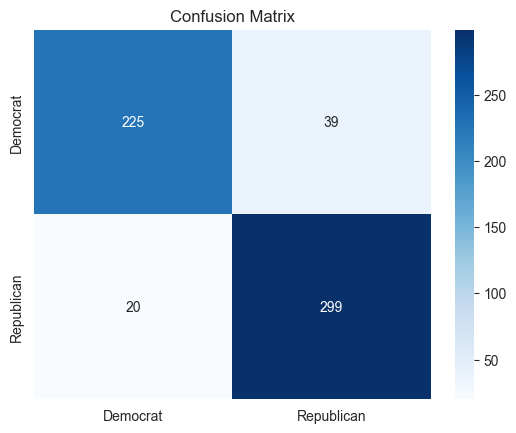

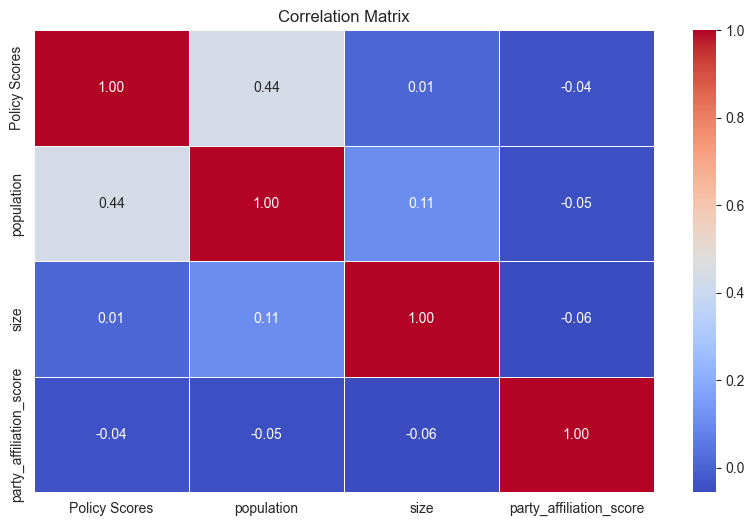

                   Feature       VIF
0                    const  1.011797
1            Policy Scores  1.240068
2               population  1.253624
3                     size  1.015965
4  party_affiliation_score  1.005529


In [47]:
analyze_political_party(final_df_imputed_normalized)

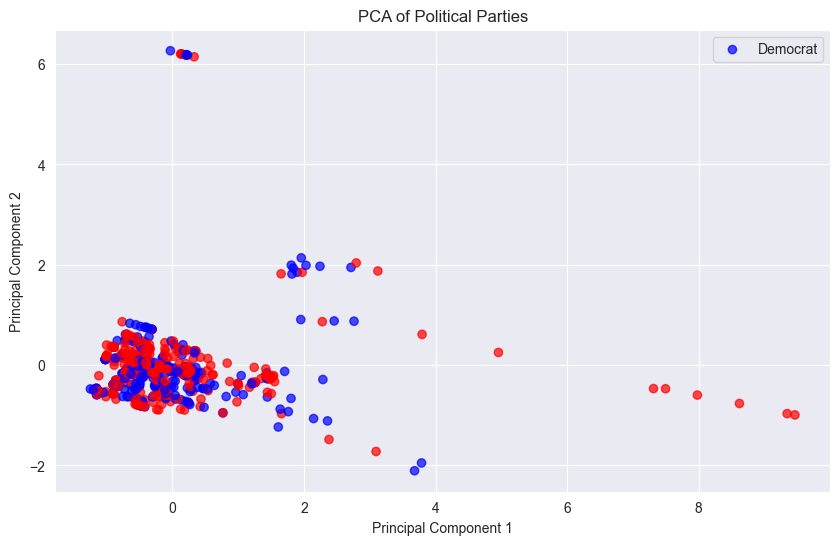

Accuracy: 0.5471698113207547


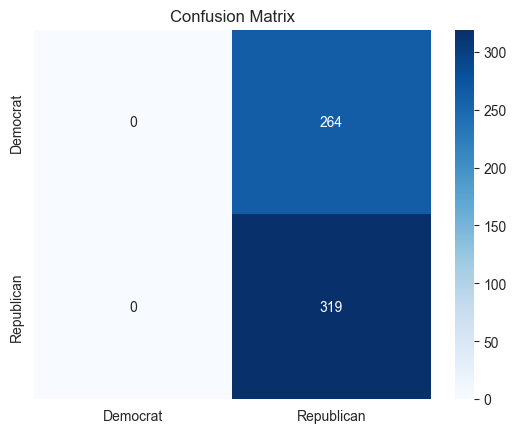

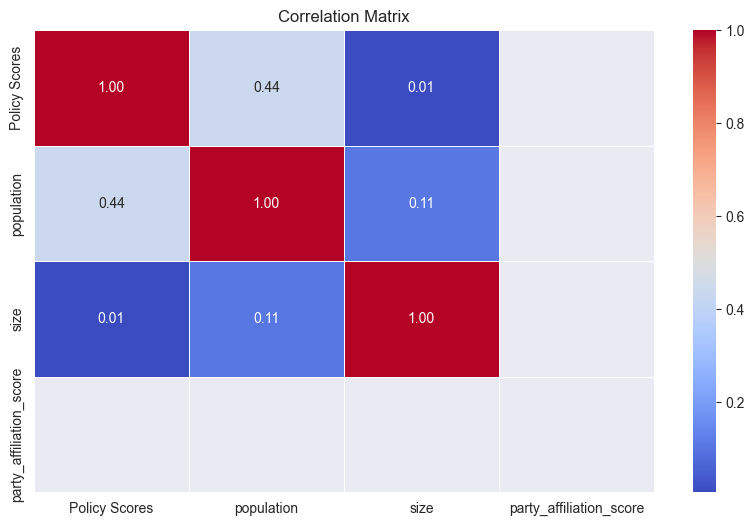

                   Feature       VIF
0                    const  1.000000
1            Policy Scores  1.239115
2               population  1.252906
3                     size  1.013150
4  party_affiliation_score       NaN


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1752: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


In [48]:
analyze_political_party(without_party_score_df)

#### Non-imputed

In [49]:
without_party_score_df = final_df_dropped_normalized.drop(columns='party_affiliation_score')

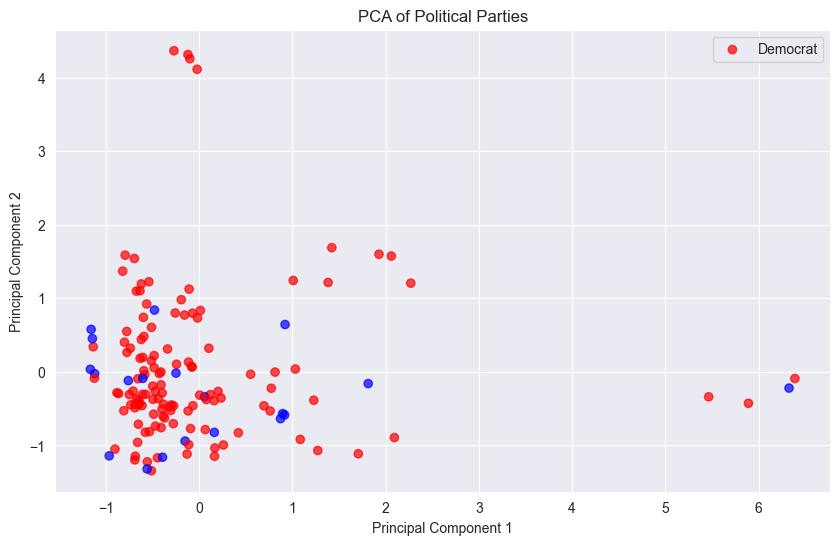

Accuracy: 0.8611111111111112


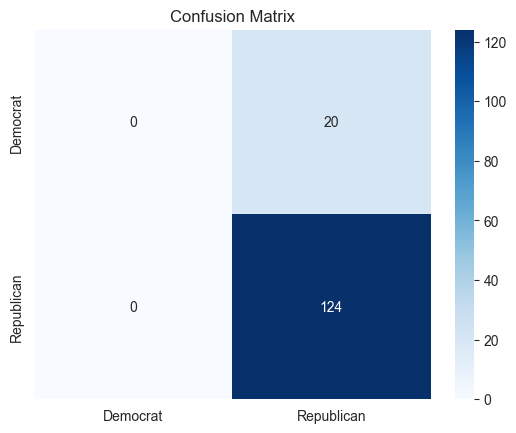

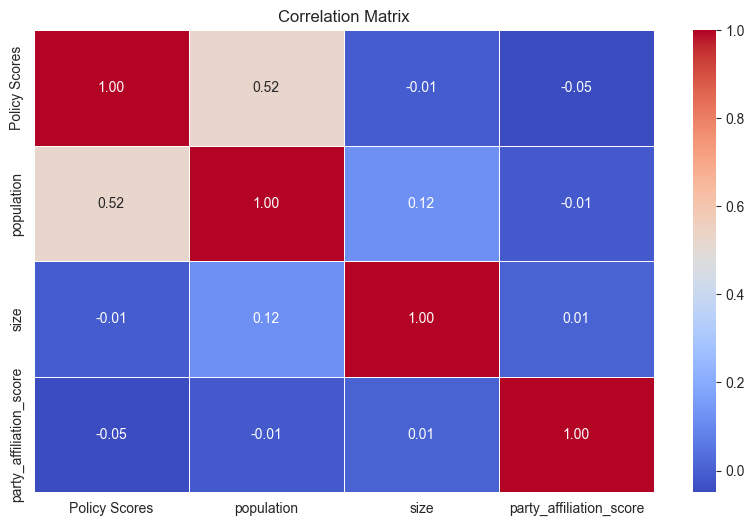

                   Feature       VIF
0                    const  1.027865
1            Policy Scores  1.393438
2               population  1.411451
3                     size  1.023503
4  party_affiliation_score  1.002598


In [50]:
analyze_political_party(final_df_dropped_normalized)

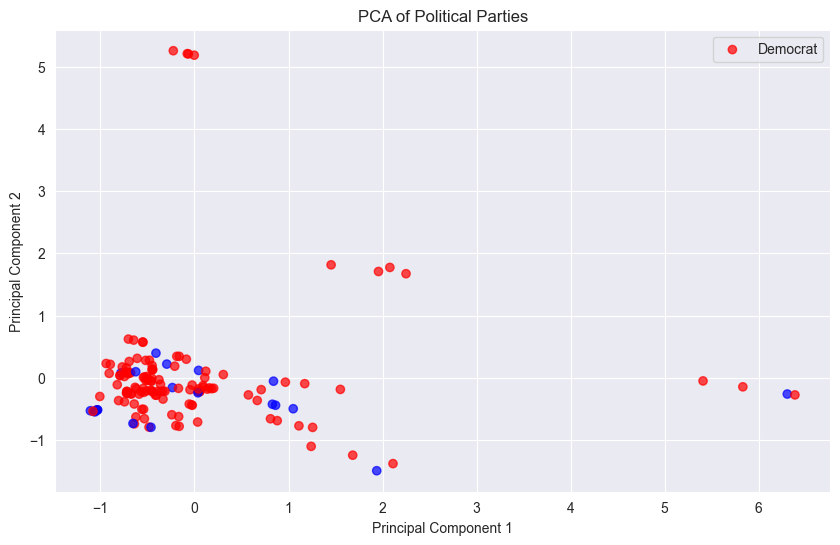

Accuracy: 0.8611111111111112


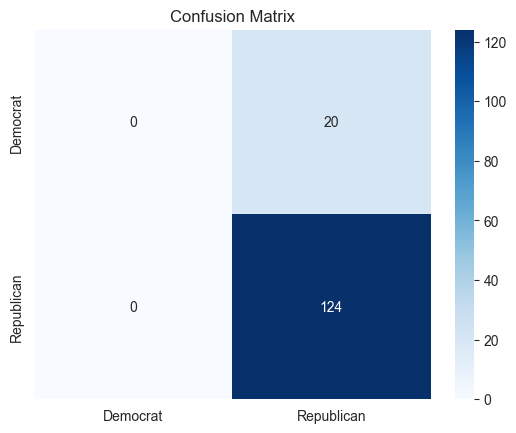

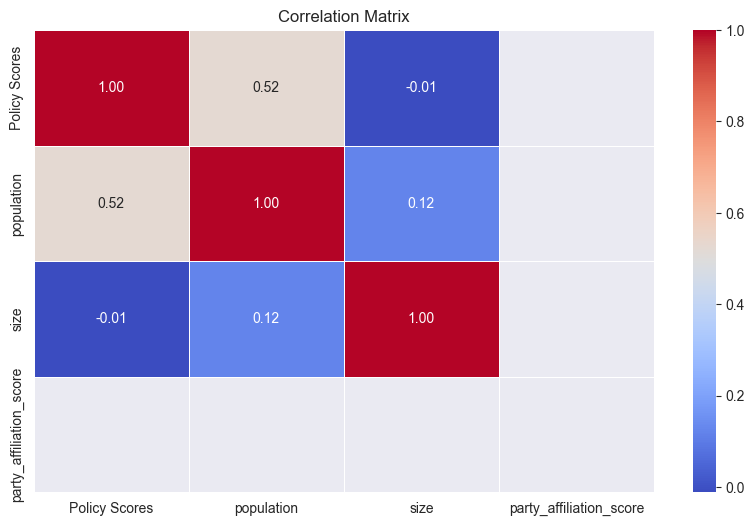

                   Feature       VIF
0                    const  1.000000
1            Policy Scores  1.390184
2               population  1.411220
3                     size  1.023496
4  party_affiliation_score       NaN


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1752: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


In [51]:
analyze_political_party(without_party_score_df)